In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pymc3 as pm

Arka arkaya yaptığımız gözlemler her zaman aynı dağılımdan gelmeyebilir. Doğal şartlar veya sosyal durum değişebilir, ve gözlemlerimiz eskisinden farklı bir modele uymak zorunda kalabilir. Böyle bir değişimi veriye baktığımızda anlyabiliriz, ama tam ne zaman değiştiğini anlamakta zorlanabiliriz.

Örnek olarak, 1851-1962 arasında İngiltere'de gerçekleşen kömür madeni kazalarının verilerine bakalım. ([Kaynak](http://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters))

(Arada iki yıl için veri mevcut olmadığı için bir NumPy masked array kullanıyoruz.)

/home/kaan/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


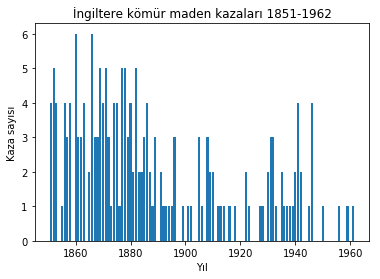

In [18]:
kaza_veri = np.ma.masked_equal([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
yıllar = np.arange(1851, 1962)

plt.bar(yıllar, kaza_veri)
plt.title("İngiltere kömür maden kazaları 1851-1962")
plt.ylabel("Kaza sayısı")
plt.xlabel("Yıl");

İlk ve son yıllar arasında fark görüyoruz: 1900'lerde kazalar daha az, ve kazasız yıllar daha fazla. 1900 yılı civarında kaza oranlarında bir değişim olduğunu tahmin ediyoruz.

Bir yıl içinde _k_ maden kazası olması ihtimalini Poisson dağılımıyla modelleyebiliriz.

$$ p(k\ |\ \lambda) = \mathrm{e}^{-\lambda}\frac{\lambda^k}{k!}$$

Dağılımın $\lambda$ parametresi teorik olarak beklenen kaza sayısına eşittir.

Kazaların her zaman Poisson dağılımına uyduğunu, ama başta ve sondaki $\lambda$ parametrelerinin farklı olduğunu varsayarak model kuracağız. Değişim yılını bir rastgele değişken olarak ekleyelim.

In [19]:
with pm.Model() as kaza_modeli:

    # Değişim yılı için önsel: Yıllar üzerinde düzgün ayrık dağılım
    değişimyılı = pm.DiscreteUniform('değişimyılı', lower=yıllar.min(), upper=yıllar.max(), testval=1900)

    # Değişimden önceki ve sonraki kaza sayıları oranlarının önselleri
    önceki_oran = pm.Exponential('önceki_oran', 1)
    sonraki_oran = pm.Exponential('sonraki_oran', 1)

    # Değişim yılından önceki ve sonraki yıllara uygun Poisson oranları ata.
    oranlar = pm.math.switch(değişimyılı >= yıllar, önceki_oran, sonraki_oran)

    # Olabilirlik
    kazalar = pm.Poisson('kazalar', oranlar, observed=kaza_veri)

In [20]:
with kaza_modeli:
    zincir = pm.sample(10000)

Assigned Metropolis to değişimyılı
Assigned NUTS to önceki_oran_log_
Assigned NUTS to sonraki_oran_log_
Assigned Metropolis to kazalar_missing
100%|██████████| 10000/10000 [00:15<00:00, 666.59it/s]


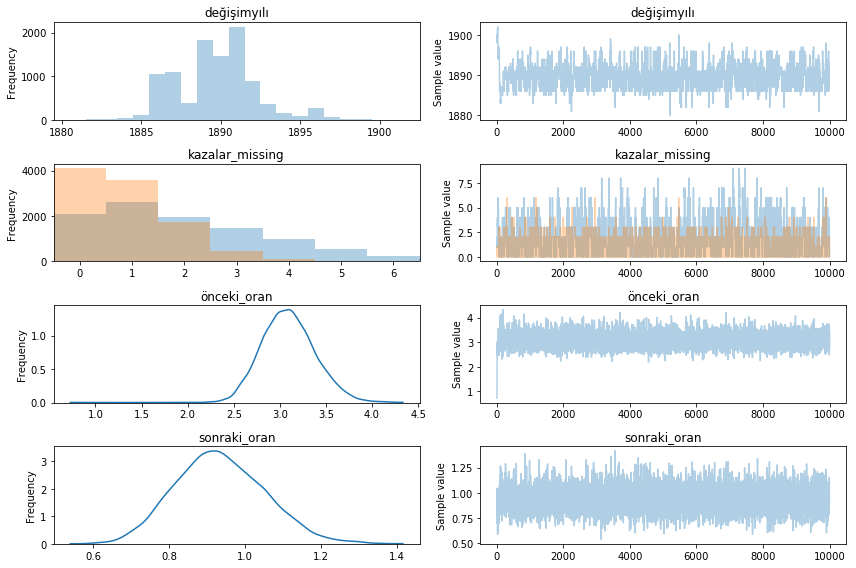

In [21]:
pm.traceplot(zincir);

In [22]:
pm.summary(zincir)


değişimyılı:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1889.710         2.581            0.104            [1885.000, 1895.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1886.000       1888.000       1890.000       1891.000       1896.000


kazalar_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.990            1.691            0.077            [0.000, 5.000]
  0.906            0.970            0.026            [0.000, 3.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          1.000          2.000          3.000          6.000
  0.000       

Görüyoruz ki, 1888-1892 yılları arasında gerçekleşen bir değişim sayesinde, yılda üçten fazla olan maden kazası oranı, yılda birin altına düşmüş. 

## Çalışma

1. İki farklı parametre ile Poisson dağılımı kullanarak benzeri bir sentetik veri kümesi üretin ve modeli bu veriyle eğitin.

1. Hepsi aynı Poisson parametresiyle üretilen bir veri dizisi oluşturun ve modeli tekrar eğitin. Değişim noktası olarak ne elde ediyorsunuz?

1. *İki* değişim noktası, yani üç ayrı Poisson parametresi ile yeni bir sentetik veri dizisi oluşturun. Modeli iki değişim noktası kullanabilecek şekilde değiştirin ve eğitin.

## Çözüm

### 1. Sentetik veri, tek değişim noktası

In [23]:
λ1, λ2 = 2,4
td = 45
n = 100

In [28]:
veri1 = np.random.poisson(λ1, td)
veri2 = np.random.poisson(λ2, n-td)
veri = np.hstack((veri1, veri2))

In [36]:
with pm.Model() as ikili_model:

    # Değişim zamanı için önsel: Düzgün ayrık dağılım
    değişim = pm.DiscreteUniform('değişim', lower=0, upper=n)

    # Değişimden önceki ve sonraki parametre önselleri
    lam1 = pm.Exponential('lam1', 1)
    lam2 = pm.Exponential('lam2', 1)

    # Değişim yılından önceki ve sonraki yıllara uygun Poisson oranları ata.
    oranlar = pm.math.switch(değişim >= np.arange(n), lam1, lam2)

    # Olabilirlik
    sayılar = pm.Poisson('sayılar', oranlar, observed=veri)
    
    zincir2 = pm.sample(20000)

Assigned Metropolis to değişim
Assigned NUTS to lam1_log_
Assigned NUTS to lam2_log_
100%|██████████| 20000/20000 [00:21<00:00, 918.65it/s] 


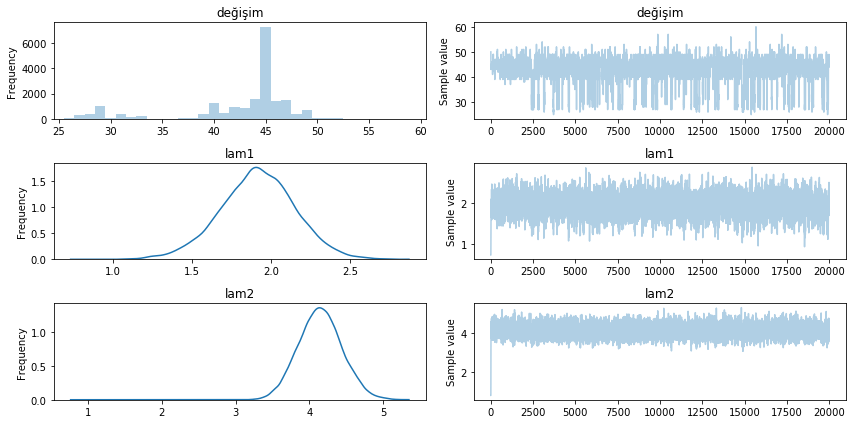

In [37]:
pm.traceplot(zincir2);

In [38]:
pm.summary(zincir2[10000:])


değişim:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  42.276           6.016            0.353            [28.000, 49.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  28.000         41.000         45.000         45.000         49.000


lam1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.914            0.244            0.008            [1.407, 2.386]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.404          1.758          1.919          2.075          2.384


lam2:

  Mean             SD               MC Error         95% HPD interval
  ----------------------

### 2. Değişimsiz veri seti

In [39]:
λ1 = 3
n = 100
veri = np.random.poisson(λ1, n)

In [43]:
with pm.Model() as ikili_model:

    # Değişim zamanı için önsel: Düzgün ayrık dağılım
    değişim = pm.DiscreteUniform('değişim', lower=0, upper=n)

    # Değişimden önceki ve sonraki parametre önselleri
    lam1 = pm.Exponential('lam1', 1)
    lam2 = pm.Exponential('lam2', 1)

    # Değişim yılından önceki ve sonraki yıllara uygun Poisson oranları ata.
    oranlar = pm.math.switch(değişim >= np.arange(n), lam1, lam2)

    # Olabilirlik
    sayılar = pm.Poisson('sayılar', oranlar, observed=veri)
    
    zincir2 = pm.sample(10000)

Assigned Metropolis to değişim
Assigned NUTS to lam1_log_
Assigned NUTS to lam2_log_
100%|██████████| 10000/10000 [00:16<00:00, 624.35it/s]


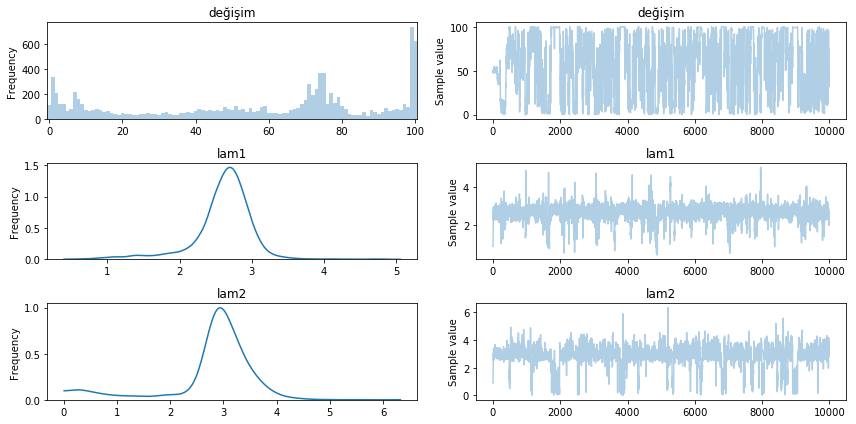

In [44]:
pm.traceplot(zincir2);

In [45]:
pm.summary(zincir2)


değişim:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  57.026           32.904           2.070            [2.000, 100.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.000          28.000         68.000         80.000         100.000


lam1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.606            0.427            0.018            [1.543, 3.363]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.391          2.467          2.663          2.834          3.233


lam2:

  Mean             SD               MC Error         95% HPD interval
  ---------------------

Bir değişim noktalı modeli, hiç değişim olmayan veriyle eğitirsek değişim noktası aralığın sonunda çıkıyor ve her iki parametre birbirine yakın çıkıyor.

### 3. İki değişim noktası

In [61]:
λ1, λ2, λ3 = 2,4,1
td1, td2 = 30, 70
n = 100

veri1 = np.random.poisson(λ1, td1)
veri2 = np.random.poisson(λ2, td2-td1)
veri3 = np.random.poisson(λ3, n-td2)
veri = np.hstack((veri1, veri2, veri3))

In [62]:
with pm.Model() as üçlü_model:

    # Değişim zamanı için önsel: Düzgün ayrık dağılım
    değişim1 = pm.DiscreteUniform('değişim1', lower=0, upper=n, testval=50)
    değişim2 = pm.DiscreteUniform('değişim2', lower=0, upper=n, testval=80)

    # Değişimden önceki ve sonraki parametre önselleri
    lam1 = pm.Exponential('lam1', 1)
    lam2 = pm.Exponential('lam2', 1)
    lam3 = pm.Exponential('lam3', 1)

    # Değişim yılından önceki ve sonraki yıllara uygun Poisson oranları ata.
    oranlar = pm.math.switch(değişim1 >= np.arange(n), lam1, pm.math.switch(değişim2>=np.arange(n), lam2, lam3))
    # Olabilirlik
    sayılar = pm.Poisson('sayılar', oranlar, observed=veri)
    
    zincir3 = pm.sample(20000)

Assigned Metropolis to değişim1
Assigned Metropolis to değişim2
Assigned NUTS to lam1_log_
Assigned NUTS to lam2_log_
Assigned NUTS to lam3_log_
100%|██████████| 20000/20000 [00:36<00:00, 546.05it/s]


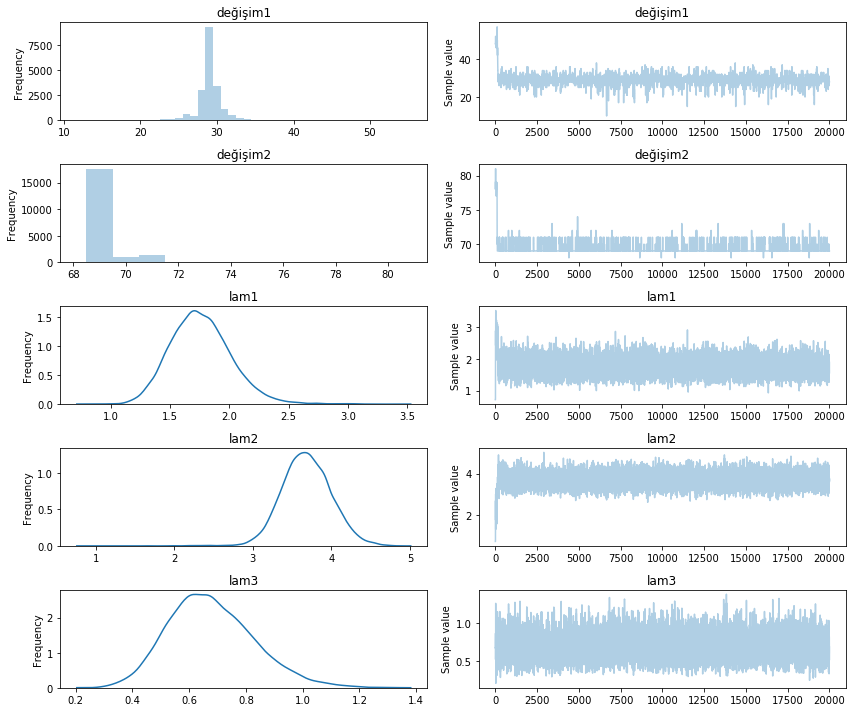

In [63]:
pm.traceplot(zincir3);

In [64]:
pm.summary(zincir3)


değişim1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  29.132           2.501            0.146            [25.000, 33.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  25.000         29.000         29.000         30.000         33.000


değişim2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  69.234           0.863            0.048            [69.000, 71.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  69.000         69.000         69.000         69.000         71.000


lam1:

  Mean             SD               MC Error         95% HPD interval
  --------------

Model bu haliyle biraz başarılı, ama çok değil. Ancak `değişim1` ve `değişim2` değişkenlerinin desteklerini daraltırsak daha iyi sonuç elde ediyoruz.

In [65]:
with pm.Model() as üçlü_model:

    # Değişim zamanı için önsel: Düzgün ayrık dağılım
    değişim1 = pm.DiscreteUniform('değişim1', lower=0, upper=75)
    değişim2 = pm.DiscreteUniform('değişim2', lower=25, upper=n)

    # Değişimden önceki ve sonraki parametre önselleri
    lam1 = pm.Exponential('lam1', 1)
    lam2 = pm.Exponential('lam2', 1)
    lam3 = pm.Exponential('lam3', 1)

    # Değişim yılından önceki ve sonraki yıllara uygun Poisson oranları ata.
    oranlar = pm.math.switch(değişim1 >= np.arange(n), lam1, pm.math.switch(değişim2>=np.arange(n), lam2, lam3))
    # Olabilirlik
    sayılar = pm.Poisson('sayılar', oranlar, observed=veri)
    
    zincir3 = pm.sample(20000)

Assigned Metropolis to değişim1
Assigned Metropolis to değişim2
Assigned NUTS to lam1_log_
Assigned NUTS to lam2_log_
Assigned NUTS to lam3_log_
100%|██████████| 20000/20000 [02:02<00:00, 163.15it/s]


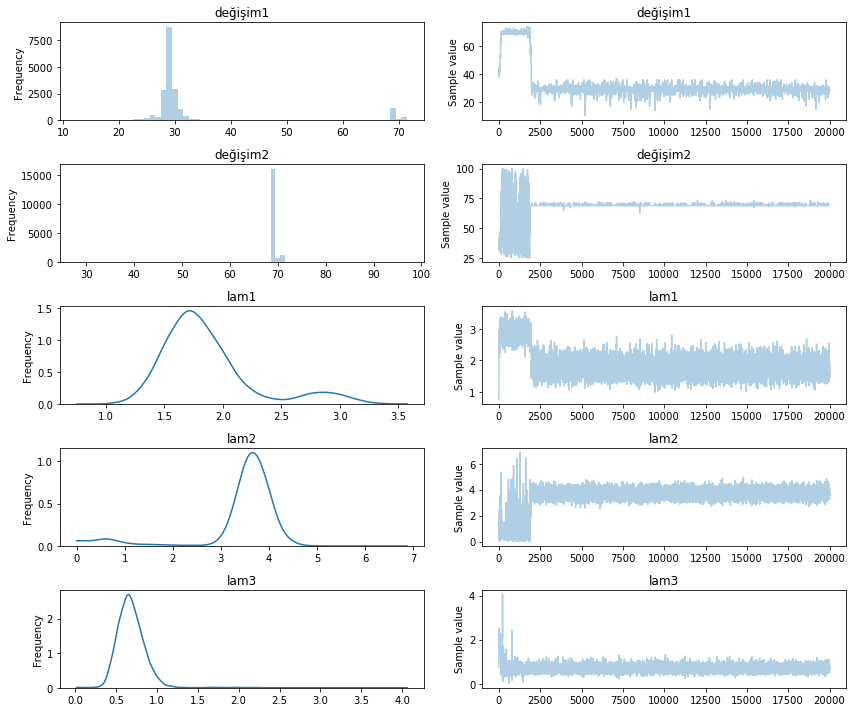

In [66]:
pm.traceplot(zincir3);

In [67]:
pm.summary(zincir3[2500:])


değişim1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  28.978           1.910            0.048            [24.000, 32.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  25.000         29.000         29.000         30.000         33.000


değişim2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  69.175           0.594            0.017            [69.000, 71.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  69.000         69.000         69.000         69.000         71.000


lam1:

  Mean             SD               MC Error         95% HPD interval
  --------------